In [1]:
using Arrhenius
using ForwardDiff
using LinearAlgebra
using DiffEqSensitivity
using DifferentialEquations

using Random
using ProgressBars
using DelimitedFiles
using Plots, Colors, Printf, Profile
Threads.nthreads() = 16;

In [2]:
using Flux
using Flux: crossentropy
using Flux.Losses: mae, mse
using Flux.Optimise: update!
using LatinHypercubeSampling
using Statistics

In [3]:
gas = CreateSolution("../../mechanism/JP10skeletal.yaml");
ns = gas.n_species;
nr = gas.n_reactions;
gas.species_names;

Y0 = zeros(ns);
Y0[species_index(gas, "C10H16")] = 0.05;
Y0[species_index(gas, "N2")] = 0.95;
T0 = 1200.0;
P = one_atm;
u0 = vcat(Y0, T0);

In [4]:
# settings
solver = TRBDF2();

datasize = 50;
tsteps = 10 .^ range(log10(1e-8), log10(1e-1), length=datasize);
tspan = [0.0, tsteps[end]*1.001];

rng = MersenneTwister(0x7777777);
p_true = zeros(nr);
p_pred = 1.0*(2*rand(rng, nr).-1);
p_init = deepcopy(p_pred);

grad_max = 10 ^ (1);

In [5]:
# ODE function
@inbounds function dudtp!(du, u, p, t)
    T = u[end]
    Y = @view(u[1:ns])
    
    mean_MW = 1. / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    
    qdot = wdot_func(gas.reaction, T, C, S0, h_mole, get_qdot = true)
    wdot = gas.reaction.vk * (qdot .* exp.(p))
    
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end

dudtp! (generic function with 1 method)

In [6]:
n_exp_train = 20;
n_exp_valid = 5;
n_exp = n_exp_train + n_exp_valid;

abstol = 1e-9;
reltol = 1e-12;

ns = gas.n_species;

rng = MersenneTwister(0x7777777);

u0_list = zeros(Float64, (n_exp, ns+1));
randvals = randomLHC(rng, n_exp, 2) ./ n_exp;
for i in range(1, length=n_exp)
    Y0 = zeros(ns);
    if i <= n_exp_train
        T0 = 1000 + 200*randvals[i,1]; # 1000-1200K
        val = 0.02 + 0.18*randvals[i,2]; # Y[JP10] = 0.02-0.2
    else
        T0 = 1200 + 200*randvals[i,1]; # 1200-1400K
        val = 0.2 + 0.1*randvals[i,2]; # Y[JP10] = 0.2-0.3
    end
    Y0[species_index(gas, "C10H16")] = val;
    Y0[species_index(gas, "N2")] = 1 - val;
    u0 = vcat(Y0, T0);
    u0_list[i,:] = u0;
end
P = one_atm;

datasize = 10;
tsteps = 10 .^ range(log10(1e-6), log10(1e-1), length=datasize);

datadense = 100;
tdense = 10 .^ range(log10(1e-6), log10(1e-1), length=datadense);

tspan = [0.0, tsteps[end]*1.001];

train_idx = [
    species_index(gas, "C2H4"),
    species_index(gas, "CH4"),
]

# 5opt
# train_idx = [
#     species_index(gas, "C10H16"),
#     species_index(gas, "C2H4"),
#     species_index(gas, "C5H6"),
#     species_index(gas, "CH4"),
#     ns+1 # Temperature
# ]

# train_idx = 1:(ns+1);

y_true_list = zeros(Float64, (n_exp, ns+1, datasize));
y_init_list = zeros(Float64, (n_exp, ns+1, datadense));
yscale_list = [];

max_min(y) = maximum(y, dims=2) .- minimum(y, dims=2);
for i = 1:n_exp
    u0 = u0_list[i, :]
    _prob = ODEProblem(dudtp!, u0, tspan, p_true)
    y_true = Array(solve(_prob, solver, saveat=tsteps, abstol=abstol, reltol=reltol))
    y_true_list[i, :, :] = y_true
    push!(yscale_list, max_min(y_true))
end
yscale_raw = maximum(abs.(hcat(yscale_list...)), dims=2);
yscale = max.(yscale_raw, 1e-16);

for i = 1:n_exp
    u0 = u0_list[i, :]
    _prob = ODEProblem(dudtp!, u0, tspan, p_init)
    y_init = Array(solve(_prob, solver, saveat=tdense, abstol=abstol, reltol=reltol))
    y_init_list[i, :, :] = y_init
end

In [7]:
noise = 0.0;
y_data_list = zeros(Float64, (n_exp, ns+1, datasize));
for i = 1:n_exp
    y_data_list[i,:,:] = (1 .+ noise * randn(ns+1)) .* y_true_list[i,:,:]
end

In [8]:
function valid(t, y_data, tdense, y_pred, xscale)
    IJulia.clear_output(true)
    
    h1 = plot(legend=false)
    plot!(t, y_data[species_index(gas, "C10H16"),:], line=(1,:scatter), msw=0, label="Groundtruth")
    plot!(tdense, y_pred[species_index(gas, "C10H16"),:], line=(1,:solid), label="Prediction")
    xticks!([0.0, 0.03, 0.06, 0.09])
    ylabel!(h1, "Y(C10H16)")
    xlabel!(h1, "Time [s]")
    
    h2 = plot(legend=false)
    plot!(t, y_data[end,:], line=(1,:scatter), msw=0, label="Groundtruth")
    plot!(tdense, y_pred[end,:], line=(1,:solid), label="Prediction")
    xticks!([0.0, 0.03, 0.06, 0.09])
    ylabel!(h2, "T [K]")
    xlabel!(h2, "Time [s]")
    
    xlim = [5e-6, 1e-1];
    scale = maximum(abs.(y_data), dims=2)
    scale = max.(scale, 1e-16)
    h3 = plot(palette=palette(:default, length(scale)), xscale=xscale,
            xlim=xlim, legend=false)
    plot!(t[2:end], (y_data[:,2:end]./scale)', line=(1, :scatter), msw=0)
    plot!(tdense[2:end], (y_pred[:,2:end]./scale)', line=(1, :solid))
    ylabel!(h3, "Normalized Y, T")
    xlabel!(h3, "Time [s]")
    
    h = plot(h1, h2, h3, layout=@layout[grid(2,1) a{0.7w}], size=(800,350), framestyle=:box, fg_legend=:transparent)
    # display(h)
    sleep(1e-9)
    return h;
end

valid (generic function with 1 method)

In [9]:
# Regularization of parameters
vecnorm(x) = sum(abs2,x)
vecnorm(p_init-p_true)

74.30739040022686

In [10]:
sensealg = ForwardDiffSensitivity()
prob = ODEProblem(dudtp!, u0, tspan);
function predict_ode(u0, p; sample = datasize)
    _prob = remake(prob, u0=u0, p=p, tspan=[0, tsteps[sample]])
    sol = solve(_prob, solver, saveat=tsteps[1:sample], sensalg=sensealg,
                reltol=reltol, abstol=abstol, verbose=false)
    pred = Array(sol)
    if sol.retcode == :Success
        nothing
    else
        println("ode solver failed")
    end
    return pred
end

function loss_ode(p, i_exp, y_data_list; abstol=1e-12, sample = datasize)
    y_pred = predict_ode(u0_list[i_exp,:], p; sample)[train_idx,:]
    y_data = y_data_list[i_exp,train_idx,1:sample]
    yscale = max.(yscale_list[i_exp], abstol)[train_idx];
    loss = mse(y_data./yscale, y_pred./yscale) + vecnorm(p-p_init)*1e-4
    return loss
end

loss_ode(p_init, 1, y_data_list)

0.003182491173959722

In [11]:
losses_y_train = Vector{Float64}();
losses_y_valid = Vector{Float64}();
losses_p = Vector{Float64}();
history_p_pred = Vector{Array{Float64}}();

# save losses
loss_epoch = zeros(Float64, n_exp);
for i_exp in 1:n_exp
    loss_epoch[i_exp] = loss_ode(p_pred, i_exp, y_data_list; abstol=abstol)
end
loss_y_train = mean(loss_epoch[1:n_exp_train]);
loss_y_valid = mean(loss_epoch[n_exp_train+1:end]);
loss_p = mae(p_pred, p_true)
push!(losses_y_train, loss_y_train)
push!(losses_y_valid, loss_y_valid)
push!(losses_p, loss_p)
push!(history_p_pred, p_init);

In [12]:
function train(opt, y_data_list; n_epoch=10, batchsize=50, reltol=1e-6, abstol=1e-9)
    epochs = ProgressBar(1:n_epoch);
    loss_epoch = zeros(Float64, n_exp);
    grad_norm = zeros(Float64, n_exp_train);
    for epoch in epochs
        # update parameters
        global p_pred
        for i_exp in randperm(n_exp_train)
            sample = rand(batchsize:datasize)
            grad = ForwardDiff.gradient(
                        x -> loss_ode(x, i_exp, y_data_list; abstol=abstol, sample),
                        p_pred)
            grad_norm[i_exp] = norm(grad, 2)
            if grad_norm[i_exp] > grad_max
                grad = grad ./ grad_norm[i_exp] .* grad_max
            end
            update!(opt, p_pred, grad)
        end

        # save losses
        for i_exp in 1:n_exp
            loss_epoch[i_exp] = loss_ode(p_pred, i_exp, y_data_list; abstol=abstol)
        end
        loss_y_train = mean(loss_epoch[1:n_exp_train]);
        loss_y_valid = mean(loss_epoch[n_exp_train+1:end]);
        loss_p = mae(p_pred, p_true)
        push!(history_p_pred, deepcopy(p_pred))
        push!(losses_y_train, loss_y_train)
        push!(losses_y_valid, loss_y_valid)
        push!(losses_p, loss_p)
        
        # show results
        if epoch%5==0
            u0 = u0_list[n_exp_train+1,:]
            _prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
            y_pred = Array(solve(_prob, solver, saveat=tdense, sensalg=sensealg,
                        reltol=reltol, abstol=abstol, verbose=false))
            valid(tsteps, y_data_list[n_exp_train+1,:,:], tdense, y_pred, :log10)
        end
        set_description(epochs, string(@sprintf("Loss ytrain %.3e yvalid %.3e p %.3e gnorm %.3e",
                    loss_y_train, loss_y_valid, loss_p, mean(grad_norm))))
    end
end

train (generic function with 1 method)

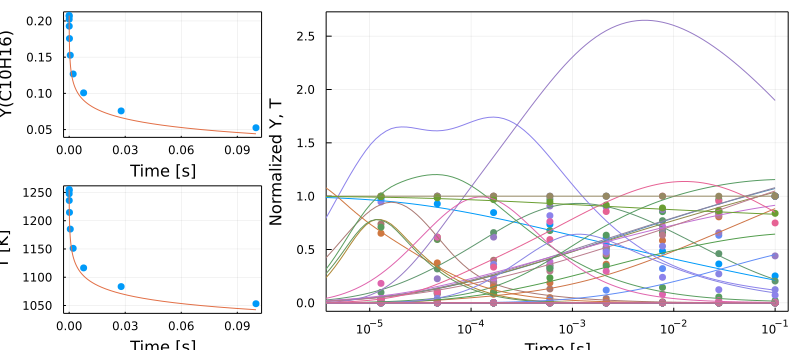

In [13]:
i_exp = n_exp_train+1
u0 = u0_list[i_exp,:]
_prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
y_pred = Array(solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false))
valid(tsteps, y_data_list[i_exp,:,:], tdense, y_pred, :log10)

In [14]:
train_idx = [ species_index(gas, "C2H4"), species_index(gas, "CH4") ]
opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=10, batchsize=5, reltol=1e-6, abstol=1e-9)

Loss ytrain 3.560e-04 yvalid 2.340e-04 p 4.836e-01 gnorm 1.297e-03 100.0%┣┫ 10/10 [10:18<00:00, 69s/it]
Loss ytrain 3.560e-04 yvalid 2.340e-04 p 4.836e-01 gnorm 1.297e-03 100.0%┣┫ 10/10 [10:18<00:00, 69s/it]


In [15]:
opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=40, batchsize=10, reltol=1e-6, abstol=1e-9)

Loss ytrain 1.315e-04 yvalid 1.693e-04 p 4.831e-01 gnorm 5.015e-04 100.0%┣┫ 40/40 [01:22:10<00:00, 126s/it]
Loss ytrain 1.315e-04 yvalid 1.693e-04 p 4.831e-01 gnorm 5.015e-04 100.0%┣┫ 40/40 [01:22:10<00:00, 126s/it]


In [16]:
opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=50, batchsize=10, reltol=1e-9, abstol=1e-12)

Loss ytrain 1.364e-04 yvalid 1.850e-04 p 4.831e-01 gnorm 5.416e-04 100.0%┣┫ 50/50 [01:44:16<00:00, 128s/it]
Loss ytrain 1.364e-04 yvalid 1.850e-04 p 4.831e-01 gnorm 5.416e-04 100.0%┣┫ 50/50 [01:44:16<00:00, 128s/it]


## Training with noises

In [17]:
noise_arr = Vector{Float64}();
p_pred_arr = Vector{Array{Float64}}();

push!(noise_arr, deepcopy(noise));
push!(p_pred_arr, deepcopy(p_pred));

**noise = 0.002**

In [18]:
noise = 0.002
y_data_list = zeros(Float64, (n_exp, ns+1, datasize));
for i = 1:n_exp
    y_data_list[i,1:ns,:] = (1 .+ noise * randn(ns,datasize)) .* y_true_list[i,1:ns,:]
    y_data_list[i,ns+1,:] = (1 .+ 0.1*noise * randn(datasize)) .* y_true_list[i,ns+1,:]
end
p_pred = deepcopy(p_init);

# i_exp = n_exp_train+1
# u0 = u0_list[i_exp,:]
# _prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
# y_pred = Array(solve(_prob, solver, saveat=tdense, sensalg=sensealg,
#             reltol=reltol, abstol=abstol, verbose=false))
# valid(tsteps, y_data_list[i_exp,:,:], tdense, y_pred, :log10)

In [19]:
train_idx = [ species_index(gas, "C2H4"), species_index(gas, "CH4") ]
opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=10, batchsize=5, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=40, batchsize=10, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=50, batchsize=10, reltol=1e-9, abstol=1e-12)

push!(noise_arr, deepcopy(noise));
push!(p_pred_arr, deepcopy(p_pred));

Loss ytrain 1.343e-04 yvalid 1.716e-04 p 4.830e-01 gnorm 6.358e-04 100.0%┣┫ 50/50 [01:43:41<00:00, 127s/it]
Loss ytrain 1.343e-04 yvalid 1.716e-04 p 4.830e-01 gnorm 6.358e-04 100.0%┣┫ 50/50 [01:43:41<00:00, 127s/it]


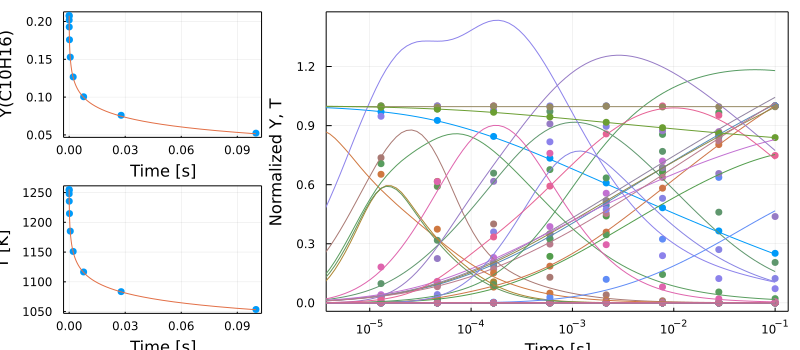

In [20]:
i_exp = n_exp_train+1
u0 = u0_list[i_exp,:]
_prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
y_pred = Array(solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false))
valid(tsteps, y_data_list[i_exp,:,:], tdense, y_pred, :log10)

**noise=0.01**

In [21]:
noise = 0.01
y_data_list = zeros(Float64, (n_exp, ns+1, datasize));
for i = 1:n_exp
    y_data_list[i,1:ns,:] = (1 .+ noise * randn(ns,datasize)) .* y_true_list[i,1:ns,:]
    y_data_list[i,ns+1,:] = (1 .+ 0.1*noise * randn(datasize)) .* y_true_list[i,ns+1,:]
end
p_pred = deepcopy(p_init);

# i_exp = n_exp_train+1
# u0 = u0_list[i_exp,:]
# _prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
# y_pred = Array(solve(_prob, solver, saveat=tdense, sensalg=sensealg,
#             reltol=reltol, abstol=abstol, verbose=false))
# valid(tsteps, y_data_list[i_exp,:,:], tdense, y_pred, :log10)

In [22]:
train_idx = [ species_index(gas, "C2H4"), species_index(gas, "CH4") ]
opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=10, batchsize=5, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=40, batchsize=10, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=50, batchsize=10, reltol=1e-9, abstol=1e-12)

push!(noise_arr, deepcopy(noise));
push!(p_pred_arr, deepcopy(p_pred));

Loss ytrain 1.533e-04 yvalid 2.261e-04 p 4.830e-01 gnorm 8.019e-04 100.0%┣┫ 50/50 [01:40:32<00:00, 123s/it]
Loss ytrain 1.533e-04 yvalid 2.261e-04 p 4.830e-01 gnorm 8.019e-04 100.0%┣┫ 50/50 [01:40:32<00:00, 123s/it]


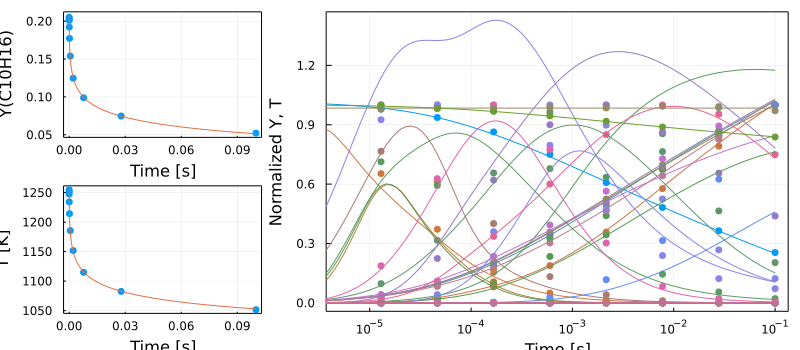

In [23]:
i_exp = n_exp_train+1
u0 = u0_list[i_exp,:]
_prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
y_pred = Array(solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false))
valid(tsteps, y_data_list[i_exp,:,:], tdense, y_pred, :log10)

**noise = 0.05**

In [24]:
noise = 0.05
y_data_list = zeros(Float64, (n_exp, ns+1, datasize));
for i = 1:n_exp
    y_data_list[i,1:ns,:] = (1 .+ noise * randn(ns,datasize)) .* y_true_list[i,1:ns,:]
    y_data_list[i,ns+1,:] = (1 .+ 0.1*noise * randn(datasize)) .* y_true_list[i,ns+1,:]
end
p_pred = deepcopy(p_init);

# i_exp = n_exp_train+1
# u0 = u0_list[i_exp,:]
# _prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
# y_pred = Array(solve(_prob, solver, saveat=tdense, sensalg=sensealg,
#             reltol=reltol, abstol=abstol, verbose=false))
# valid(tsteps, y_data_list[i_exp,:,:], tdense, y_pred, :log10)

In [25]:
train_idx = [ species_index(gas, "C2H4"), species_index(gas, "CH4") ]
opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=10, batchsize=5, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=40, batchsize=10, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=50, batchsize=10, reltol=1e-9, abstol=1e-12)

push!(noise_arr, deepcopy(noise));
push!(p_pred_arr, deepcopy(p_pred));

Loss ytrain 4.474e-04 yvalid 1.026e-03 p 4.833e-01 gnorm 2.932e-03 100.0%┣┫ 50/50 [01:42:12<00:00, 125s/it]
Loss ytrain 4.474e-04 yvalid 1.026e-03 p 4.833e-01 gnorm 2.932e-03 100.0%┣┫ 50/50 [01:42:12<00:00, 125s/it]


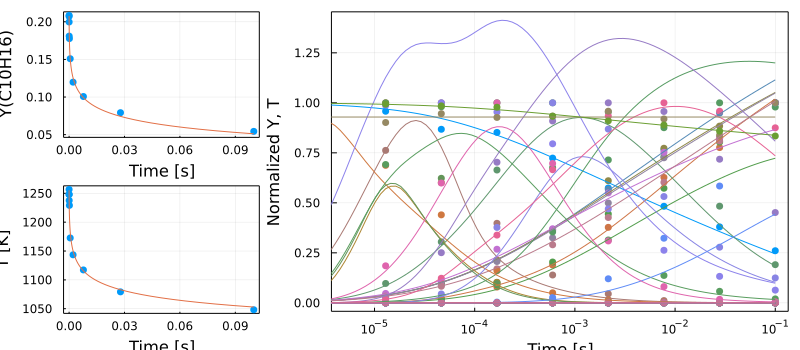

In [26]:
i_exp = n_exp_train+1
u0 = u0_list[i_exp,:]
_prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
y_pred = Array(solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false))
valid(tsteps, y_data_list[i_exp,:,:], tdense, y_pred, :log10)

In [27]:
noise = 0.25
y_data_list = zeros(Float64, (n_exp, ns+1, datasize));
for i = 1:n_exp
    y_data_list[i,1:ns,:] = (1 .+ noise * randn(ns,datasize)) .* y_true_list[i,1:ns,:]
    y_data_list[i,ns+1,:] = (1 .+ 0.1*noise * randn(datasize)) .* y_true_list[i,ns+1,:]
end
p_pred = deepcopy(p_init);

# i_exp = n_exp_train+1
# u0 = u0_list[i_exp,:]
# _prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
# y_pred = Array(solve(_prob, solver, saveat=tdense, sensalg=sensealg,
#             reltol=reltol, abstol=abstol, verbose=false))
# valid(tsteps, y_data_list[i_exp,:,:], tdense, y_pred, :log10)

In [28]:
train_idx = [ species_index(gas, "C2H4"), species_index(gas, "CH4") ]
opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=10, batchsize=5, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=40, batchsize=10, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=50, batchsize=10, reltol=1e-9, abstol=1e-12)

push!(noise_arr, deepcopy(noise));
push!(p_pred_arr, deepcopy(p_pred));

Loss ytrain 6.075e-03 yvalid 1.573e-02 p 4.821e-01 gnorm 1.159e-02 100.0%┣┫ 50/50 [01:44:14<00:00, 128s/it]
Loss ytrain 6.075e-03 yvalid 1.573e-02 p 4.821e-01 gnorm 1.159e-02 100.0%┣┫ 50/50 [01:44:14<00:00, 128s/it]


In [161]:
noise = 1.25
y_data_list = zeros(Float64, (n_exp, ns+1, datasize));
for i = 1:n_exp
    y_data_list[i,1:ns,:] = (1 .+ noise * randn(ns,datasize)) .* y_true_list[i,1:ns,:]
    y_data_list[i,ns+1,:] = (1 .+ 0.1*noise * randn(datasize)) .* y_true_list[i,ns+1,:]
end
p_pred = deepcopy(p_init);

In [162]:
train_idx = [ species_index(gas, "C2H4"), species_index(gas, "CH4") ]
opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=10, batchsize=5, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=40, batchsize=10, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=50, batchsize=10, reltol=1e-9, abstol=1e-12)

push!(noise_arr, deepcopy(noise));
push!(p_pred_arr, deepcopy(p_pred));

Loss ytrain 1.803e-01 yvalid 4.387e-01 p 5.243e-01 gnorm 8.662e-02 100.0%┣┫ 50/50 [01:35:01<00:00, 116s/it]
Loss ytrain 1.803e-01 yvalid 4.387e-01 p 5.243e-01 gnorm 8.662e-02 100.0%┣┫ 50/50 [01:35:01<00:00, 116s/it]


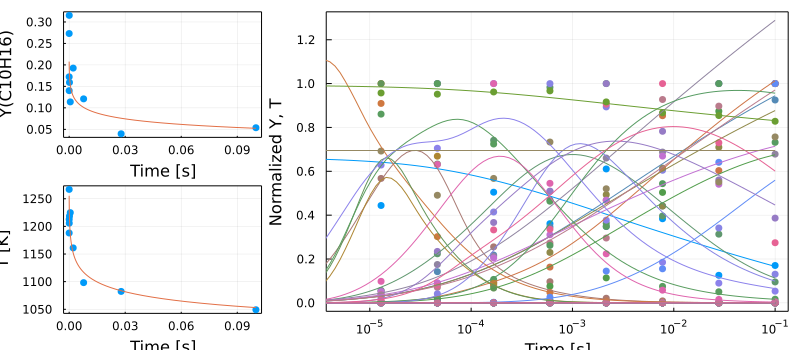

In [29]:
i_exp = n_exp_train+1
u0 = u0_list[i_exp,:]
_prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
y_pred = Array(solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false))
valid(tsteps, y_data_list[i_exp,:,:], tdense, y_pred, :log10)

**Test and Valid and Plot Accuracy**

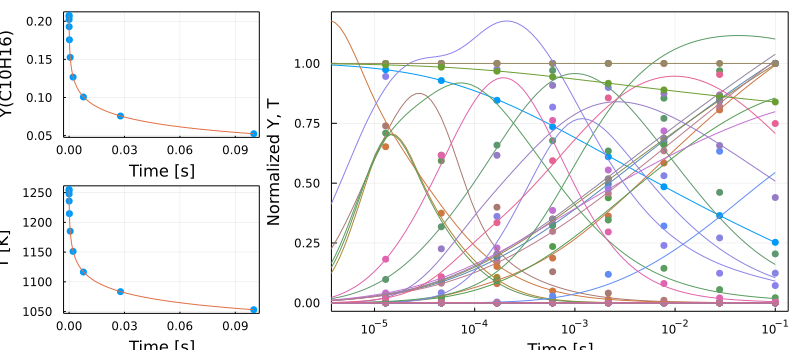

In [30]:
p_pred = p_pred_arr[end]

i_exp = n_exp_train+1
u0 = u0_list[i_exp,:]
_prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
y_pred = Array(solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false))
valid(tsteps, y_true_list[i_exp,:,:], tdense, y_pred, :log10)

In [154]:
train_idx = [ species_index(gas, "C2H4"), species_index(gas, "CH4") ]

p_loss_arr = zeros(Float64, (length(p_pred_arr), n_exp))
y_loss_arr = zeros(Float64, (length(p_pred_arr), n_exp))
for i = 1:length(p_pred_arr)
    p_pred = p_pred_arr[i]
    noises = noise_arr[i]
    for i_exp = 1:n_exp
        u0 = u0_list[i_exp,:]
        _prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
        y_pred = Array(solve(_prob, solver, saveat=tsteps, sensalg=sensealg,
                reltol=reltol, abstol=abstol, verbose=false))[train_idx,:]
        y_data = y_true_list[i_exp,train_idx,:]
        yscale = max.(yscale_list[i_exp], abstol)[train_idx]
        y_loss = mse(y_data./yscale, y_pred./yscale)
        p_loss = vecnorm((p_pred - p_init)[[1,2,170,177,190,215,232]])
        p_loss_arr[i,i_exp] = deepcopy(p_loss)
        y_loss_arr[i,i_exp] = deepcopy(y_loss)
    end
end

In [155]:
y_loss_arr

8×25 Array{Float64,2}:
 2.13414e-5  8.08499e-6  1.91427e-5   2.48876e-5   …  0.000111839  7.2412e-5
 1.85135e-5  9.46313e-6  2.32125e-5   2.90475e-5      0.000102646  6.56819e-5
 2.78359e-5  1.4755e-5   2.72747e-5   3.69622e-5      0.000122806  8.06663e-5
 1.72346e-5  1.41083e-5  2.47578e-5   3.08087e-5      7.651e-5     5.05853e-5
 4.05017e-5  7.59994e-5  0.000139984  0.000286035     9.64861e-5   7.66609e-5
 1.8005e-5   1.51545e-5  2.27872e-5   4.0874e-5    …  4.61887e-5   3.54319e-5
 1.50551e-5  5.81874e-6  8.32907e-6   1.68932e-5      4.54e-5      3.39775e-5
 1.40255e-5  4.79876e-6  8.63555e-6   2.19244e-5      5.65989e-5   4.16922e-5

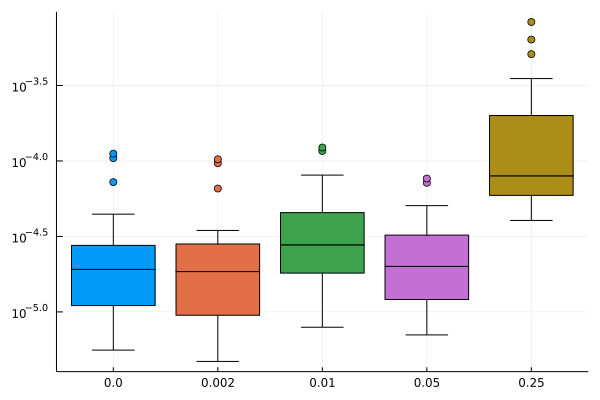

In [58]:
using StatsPlots
# idxs = [1,2,3,4,5]
# h = boxplot(y_loss_arr[idxs,1:25]', xticks=(1:5, noise_arr[idxs]), yscale=:log10, label="")
# display(h)

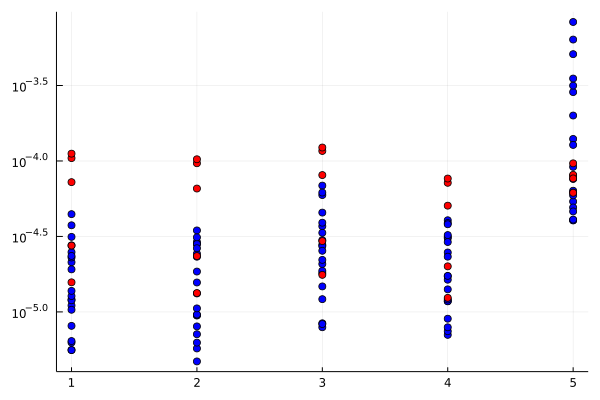

In [75]:
# idxs = [1,2,3,4,5]
# h = plot(idxs, y_loss_arr[idxs,1:20], line=(2,:scatter), markercolor=:blue, yscale=:log10, label="")
# plot!(idxs, y_loss_arr[idxs,21:25], line=(2,:scatter), markercolor=:red, yscale=:log10, label="")
# display(h)

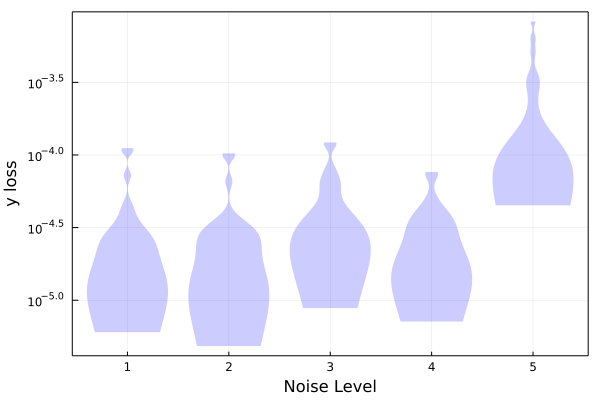

In [142]:
# using StatsPlots
# idxs = [1,2,3,4,5]
# h = plot(framestyle=:box, fg_legend=:transparent, size=(600,400))
# # violin!(y_loss_arr[idxs,1:25]', xticks=(1:5, ["0%", "0.2%", "1%", "5%", "25%"]), yscale=:log10, alpha=0.8, label="")
# violin!(y_loss_arr', line = 0, fill = (0.2, :blue), yscale=:log10, label="")
# xlabel!("Noise Level")
# ylabel!("y loss")
# display(h)
# Plots.savefig(h, "figures/JP10sk_noises_losses.svg")

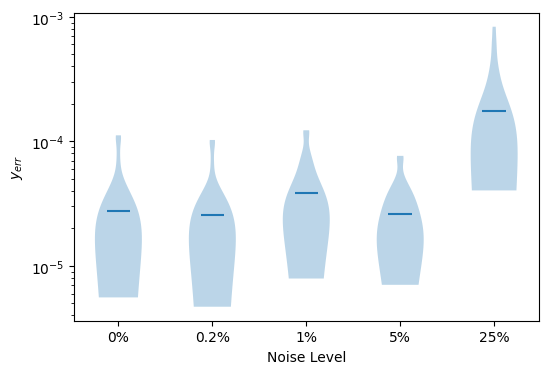

In [135]:
using PyPlot
fig = PyPlot.figure(figsize=(6,4))
PyPlot.plt.violinplot(y_loss_arr[idxs,1:25]', showmeans=true, showextrema=false)
PyPlot.plt.yscale("log")
PyPlot.plt.xticks(1:5, ["0%", "0.2%", "1%", "5%", "25%"]);
PyPlot.xlabel("Noise Level")
PyPlot.ylabel(L"$y_{err}$")
fig.savefig("figures/JP10sk_noises_losses_pyplot.svg")

In [34]:
# plot(noise_arr[idxs], p_loss_arr[idxs,1], line=(1,:scatter), xscale=:log10, yscale=:log10, label="")
vecnorm((p_pred - p_init)[[1,2,170,177,190,215,232]])

1.8613815357903702

## Traing with all species

In [143]:
noise = 0.
y_data_list = zeros(Float64, (n_exp, ns+1, datasize));
for i = 1:n_exp
    y_data_list[i,1:ns,:] = (1 .+ noise * randn(ns,datasize)) .* y_true_list[i,1:ns,:]
    y_data_list[i,ns+1,:] = (1 .+ 0.1*noise * randn(datasize)) .* y_true_list[i,ns+1,:]
end
p_pred = deepcopy(p_init);

In [144]:
train_idx = 1:(ns+1);

opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=10, batchsize=5, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=40, batchsize=10, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=50, batchsize=10, reltol=1e-9, abstol=1e-12)

push!(noise_arr, deepcopy(noise));
push!(p_pred_arr, deepcopy(p_pred));

Loss ytrain 4.471e-04 yvalid 7.462e-04 p 4.627e-01 gnorm 7.283e-04 100.0%┣┫ 50/50 [01:40:38<00:00, 123s/it]
Loss ytrain 4.471e-04 yvalid 7.462e-04 p 4.627e-01 gnorm 7.283e-04 100.0%┣┫ 50/50 [01:40:38<00:00, 123s/it]


In [157]:
noise = 0.002
y_data_list = zeros(Float64, (n_exp, ns+1, datasize));
for i = 1:n_exp
    y_data_list[i,1:ns,:] = (1 .+ noise * randn(ns,datasize)) .* y_true_list[i,1:ns,:]
    y_data_list[i,ns+1,:] = (1 .+ 0.1*noise * randn(datasize)) .* y_true_list[i,ns+1,:]
end
p_pred = deepcopy(p_init);

In [158]:
train_idx = 1:(ns+1);

opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=10, batchsize=5, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=40, batchsize=10, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=50, batchsize=10, reltol=1e-9, abstol=1e-12)

push!(noise_arr, deepcopy(noise));
push!(p_pred_arr, deepcopy(p_pred));

Loss ytrain 9.108e+16 yvalid 9.043e+16 p 4.626e-01 gnorm 7.508e-04 100.0%┣┫ 50/50 [01:37:41<00:00, 120s/it]
Loss ytrain 9.108e+16 yvalid 9.043e+16 p 4.626e-01 gnorm 7.508e-04 100.0%┣┫ 50/50 [01:37:41<00:00, 120s/it]


In [159]:
noise = 0.01
y_data_list = zeros(Float64, (n_exp, ns+1, datasize));
for i = 1:n_exp
    y_data_list[i,1:ns,:] = (1 .+ noise * randn(ns,datasize)) .* y_true_list[i,1:ns,:]
    y_data_list[i,ns+1,:] = (1 .+ 0.1*noise * randn(datasize)) .* y_true_list[i,ns+1,:]
end
p_pred = deepcopy(p_init);

In [160]:
train_idx = 1:(ns+1);

opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=10, batchsize=5, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=40, batchsize=10, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=50, batchsize=10, reltol=1e-9, abstol=1e-12)

push!(noise_arr, deepcopy(noise));
push!(p_pred_arr, deepcopy(p_pred));

Loss ytrain 1.653e+18 yvalid 1.819e+18 p 4.627e-01 gnorm 8.525e-04 100.0%┣┫ 50/50 [01:37:59<00:00, 120s/it]
Loss ytrain 1.653e+18 yvalid 1.819e+18 p 4.627e-01 gnorm 8.525e-04 100.0%┣┫ 50/50 [01:37:59<00:00, 120s/it]


In [145]:
noise = 0.05
y_data_list = zeros(Float64, (n_exp, ns+1, datasize));
for i = 1:n_exp
    y_data_list[i,1:ns,:] = (1 .+ noise * randn(ns,datasize)) .* y_true_list[i,1:ns,:]
    y_data_list[i,ns+1,:] = (1 .+ 0.1*noise * randn(datasize)) .* y_true_list[i,ns+1,:]
end
p_pred = deepcopy(p_init);

In [146]:
train_idx = 1:(ns+1);

opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=10, batchsize=5, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=40, batchsize=10, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=50, batchsize=10, reltol=1e-9, abstol=1e-12)

push!(noise_arr, deepcopy(noise));
push!(p_pred_arr, deepcopy(p_pred));

Loss ytrain 5.387e+19 yvalid 4.193e+19 p 4.624e-01 gnorm 1.632e-03 100.0%┣┫ 50/50 [01:41:04<00:00, 124s/it]
Loss ytrain 5.387e+19 yvalid 4.193e+19 p 4.624e-01 gnorm 1.632e-03 100.0%┣┫ 50/50 [01:41:04<00:00, 124s/it]


In [147]:
noise = 0.25
y_data_list = zeros(Float64, (n_exp, ns+1, datasize));
for i = 1:n_exp
    y_data_list[i,1:ns,:] = (1 .+ noise * randn(ns,datasize)) .* y_true_list[i,1:ns,:]
    y_data_list[i,ns+1,:] = (1 .+ 0.1*noise * randn(datasize)) .* y_true_list[i,ns+1,:]
end
p_pred = deepcopy(p_init);

In [148]:
train_idx = 1:(ns+1);

opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=10, batchsize=5, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=40, batchsize=10, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=50, batchsize=10, reltol=1e-9, abstol=1e-12)

push!(noise_arr, deepcopy(noise));
push!(p_pred_arr, deepcopy(p_pred));

Loss ytrain 1.300e+21 yvalid 9.243e+20 p 4.643e-01 gnorm 6.266e-03 100.0%┣┫ 50/50 [01:41:26<00:00, 124s/it]
Loss ytrain 1.300e+21 yvalid 9.243e+20 p 4.643e-01 gnorm 6.266e-03 100.0%┣┫ 50/50 [01:41:26<00:00, 124s/it]


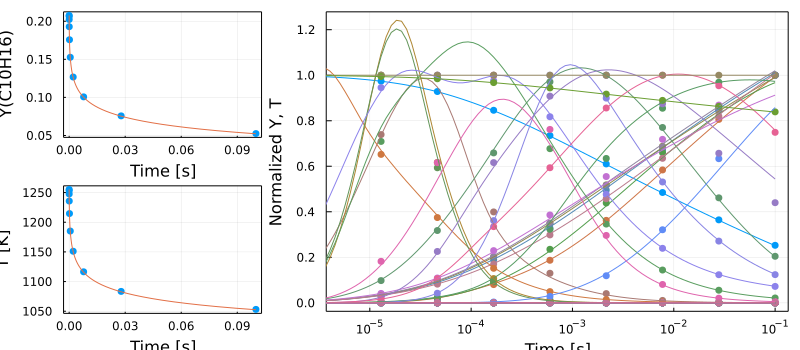

In [149]:
p_pred = p_pred_arr[end]

i_exp = n_exp_train+1
u0 = u0_list[i_exp,:]
_prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
y_pred = Array(solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false))
valid(tsteps, y_true_list[i_exp,:,:], tdense, y_pred, :log10)

In [163]:
noise = 1.25
y_data_list = zeros(Float64, (n_exp, ns+1, datasize));
for i = 1:n_exp
    y_data_list[i,1:ns,:] = (1 .+ noise * randn(ns,datasize)) .* y_true_list[i,1:ns,:]
    y_data_list[i,ns+1,:] = (1 .+ 0.1*noise * randn(datasize)) .* y_true_list[i,ns+1,:]
end
p_pred = deepcopy(p_init);

In [164]:
train_idx = 1:(ns+1);

opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=10, batchsize=5, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=40, batchsize=10, reltol=1e-6, abstol=1e-9)

opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt, y_data_list; n_epoch=50, batchsize=10, reltol=1e-9, abstol=1e-12)

push!(noise_arr, deepcopy(noise));
push!(p_pred_arr, deepcopy(p_pred));

Loss ytrain 2.805e+22 yvalid 3.109e+22 p 4.830e-01 gnorm 3.503e-02 100.0%┣┫ 50/50 [01:41:47<00:00, 125s/it]
Loss ytrain 2.805e+22 yvalid 3.109e+22 p 4.830e-01 gnorm 3.503e-02 100.0%┣┫ 50/50 [01:41:47<00:00, 125s/it]


In [194]:
train_idx = [ species_index(gas, "C2H4"), species_index(gas, "CH4") ]

p_loss_arr = zeros(Float64, (length(p_pred_arr), n_exp))
y_loss_arr = zeros(Float64, (length(p_pred_arr), n_exp))
for i = 1:length(p_pred_arr)
    p_pred = p_pred_arr[i]
    noises = noise_arr[i]
    for i_exp = 1:n_exp
        u0 = u0_list[i_exp,:]
        _prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
        y_pred = Array(solve(_prob, solver, saveat=tsteps, sensalg=sensealg,
                reltol=reltol, abstol=abstol, verbose=false))[train_idx,:]
        y_data = y_true_list[i_exp,train_idx,:]
        yscale = max.(yscale_list[i_exp], abstol)[train_idx]
        y_loss = mse(y_data./yscale, y_pred./yscale)
        p_loss = vecnorm((p_pred - p_init)[[1,2,170,177,190,215,232]])
        p_loss_arr[i,i_exp] = deepcopy(p_loss)
        y_loss_arr[i,i_exp] = deepcopy(y_loss)
    end
end

In [195]:
train_idx = 1:(ns+1);

p_loss_new = zeros(Float64, (length(p_pred_arr), n_exp))
y_loss_new = zeros(Float64, (length(p_pred_arr), n_exp))
for i = 1:length(p_pred_arr)
    p_pred = p_pred_arr[i]
    noises = noise_arr[i]
    for i_exp = 1:n_exp
        u0 = u0_list[i_exp,:]
        _prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
        y_pred = Array(solve(_prob, solver, saveat=tsteps, sensalg=sensealg,
                reltol=reltol, abstol=abstol, verbose=false))[train_idx,:]
        y_data = y_true_list[i_exp,train_idx,:]
        yscale = max.(yscale_list[i_exp], abstol)[train_idx]
        y_loss = mse(y_data./yscale, y_pred./yscale)
        p_loss = vecnorm((p_pred - p_init)[[1,2,170,177,190,215,232]])
        p_loss_new[i,i_exp] = deepcopy(p_loss)
        y_loss_new[i,i_exp] = deepcopy(y_loss)
    end
end

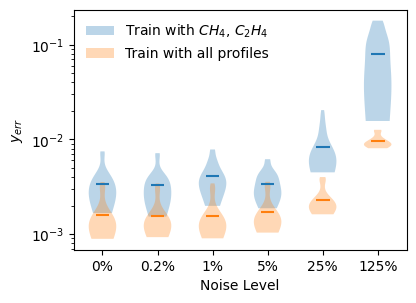

In [231]:
using PyPlot
fig = PyPlot.figure(figsize=(4.5,3))
idxs = [1,2,3,4,5,11]
h1 = PyPlot.plt.violinplot(sqrt.(y_loss_arr[idxs,1:25]'./2), showmeans=true, showextrema=false)
idxs = [6,9,10,7,8,12]
h2 = PyPlot.plt.violinplot(sqrt.(y_loss_new[idxs,1:25]'./(ns+1)), showmeans=true, showextrema=false)
PyPlot.plt.yscale("log")
PyPlot.plt.xticks(1:6, ["0%", "0.2%", "1%", "5%", "25%", "125%"]);
PyPlot.xlabel("Noise Level")
PyPlot.ylabel(L"$y_{err}$")
PyPlot.legend(handles=[h1["bodies"][1],h2["bodies"][1]],
              labels=[L"Train with $CH_4$, $C_2H_4$", "Train with all profiles"],
              loc="upper left", frameon=false)
PyPlot.plt.subplots_adjust(top=0.96, bottom=0.16, left=0.16)
fig.savefig("figures/JP10sk_w-wo_noises_losses_pyplot.svg")